## Project Overview
#### You hvae been assigned to forecast the next day of the US 10 year treasury constant rate bast on the Covid-19 time period. You goal is to try to forecast the next trading/business day based on this time frame. Use yout knowledge of Python and Convolutonal Neural Networks to create a close to but arrucate forecast for the nefxt day

## Project Approach
#### The Covid- 19 era has been something that has necvver been seen before in the history of the country, so to try to use a full data set on this forecast wold provied inadequate results. We will need to take into accunt only 2020 and the movment of the US 10 year treasury maturity rate. 

#### Our daa will be cited from the FREDs website 
https://fred.stlouisfed.org/series/DGS10


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data
- Below we will import 1 year of data collected the federal Reserve website
- We will check for missing data as well as the data types
- We can see initially thr the values of the Treasury rate is not a numeric type and needs to be converted
- There after we will work with only 2020 data to take into account COVId-19


In [8]:
ten_Year_Treasury = pd.read_csv("resources/10_year_treasury.csv", parse_dates = True, index_col = "DATE")

In [10]:
ten_Year_Treasury.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263 entries, 2019-05-07 to 2020-05-07
Data columns (total 1 columns):
DGS10    263 non-null object
dtypes: object(1)
memory usage: 4.1+ KB


### Data cleaning
- Change the column to a value we understand
- Convert rates to numeric 
- remove "." values and replace with either 0 or nan
- Extraxt 2020 data 

In [14]:
ten_Year_Treasury.columns = ["rate"]

In [16]:
ten_Year_Treasury = ten_Year_Treasury[ten_Year_Treasury["rate"] != "."]

In [18]:
ten_Year_Treasury = pd.to_numeric(ten_Year_Treasury["rate"])

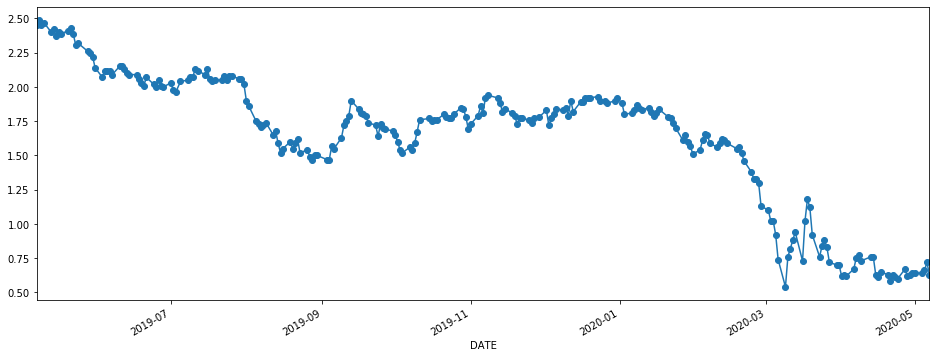

In [22]:
ten_Year_Treasury.plot(figsize = (16,6), marker = "o")

In [23]:
ten_Year_Treasury_2020  = ten_Year_Treasury.loc["2020-1-1":]

In [35]:
ten_Year_Treasury_2020.loc["2020-2-10":]

DATE
2020-02-10    1.56
2020-02-11    1.59
2020-02-12    1.62
2020-02-13    1.61
2020-02-14    1.59
              ... 
2020-05-01    0.64
2020-05-04    0.64
2020-05-05    0.66
2020-05-06    0.72
2020-05-07    0.63
Name: rate, Length: 62, dtype: float64

### Data Visualization
- WE can see a drop in the 10 year Treasury beginning on the 12 of february
- There was somewhat of a jump in March around the 16th but took a fall the next day

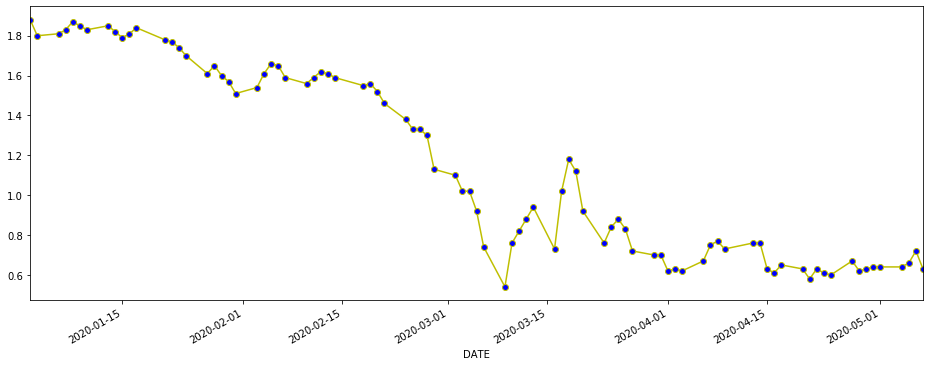

In [29]:
ten_Year_Treasury_2020.plot(figsize = (16,6), marker = "o", c = "y", mfc = "b")

### Data Prepration 
- What we need to decide here is that the COVID ourbreak became an economic issue in early March so the question is this
- Whould we use data for the entire 2020 or from March to current? 
- It would probably be more effective to use the entire year to provide the model enough data to train on but if our forecast is off significantly we will need to return to this idea

In [39]:
ten_Year_Treasury_2020 =pd.DataFrame(ten_Year_Treasury_2020)

## Data Sample
- We will be working with 88 days of data 
- Our testing sample should be a good size to recignize patterns 
- We will use 30 days of data (assuming 253 business days)

In [41]:
ten_Year_Treasury_2020.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88 entries, 2020-01-02 to 2020-05-07
Data columns (total 1 columns):
rate    88 non-null float64
dtypes: float64(1)
memory usage: 3.9 KB


In [42]:
testing_sample = 30

In [44]:
testing_index = len(ten_Year_Treasury_2020) - testing_sample

In [45]:
testing_index

58

### Training and Testing Data

In [46]:
train = ten_Year_Treasury_2020.iloc[:testing_index]

In [47]:
test = ten_Year_Treasury_2020.iloc[testing_index:]

In [48]:
train.shape

(58, 1)

### Testing Dataset 
- We have our 30 days 

In [49]:
test.shape

(30, 1)

### Scaling the data
- We must scale the data to consider the full range of the data Variance

In [50]:
from sklearn.preprocessing import MinMaxScaler

In [51]:
scalar = MinMaxScaler()

In [52]:
train_scaled = scalar.fit_transform(train)

In [53]:
test_scaled = scalar.transform(test)

In [54]:
train.shape

(58, 1)

In [55]:
test.shape

(30, 1)

## Time Series Generator
- WE will use our new scaled data with a time series generator to train out model
- Length we will use is a length of 5, will represent 5 days that our model will attempt to predict
- Though we will only focus on the first day out

In [57]:
length = 5

In [58]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [59]:
generator = TimeseriesGenerator(train_scaled,train_scaled, length=length, batch_size=1)

### Validation Gen
- Will use a validation generator to to train against 

In [60]:
valid_gen =TimeseriesGenerator(test_scaled,test_scaled, length=length, batch_size=1)

### Early Stopping
- Will use to prevent overtraining and not limit the epoch size

In [61]:
from tensorflow.keras.callbacks import EarlyStopping

In [63]:
stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

### Newtork/Model Creation 
- Will use a LSTM to prevent gradient Decay for beter learning and results
- number of features we are trying ot predict will be 1(value of rate)

In [65]:
n_features = 1

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [67]:
model = Sequential()
model.add(LSTM(units = 150, activation = "relu", input_shape = (length,n_features)))
model.add(Dense(units = 1))
model.compile(loss = "mse", optimizer = "adam")

### Fitting the Model 
- Will add our generators and calllbacks to the fit for better results 

In [68]:
model.fit_generator(generator=generator, validation_data=valid_gen, epochs=10, callbacks=[stop])

Epoch 1/10
53/53 [==============================] - 12s 233ms/step - loss: 0.0993 - val_loss: 0.0190
Epoch 2/10
53/53 [==============================] - 12s 222ms/step - loss: 0.0127 - val_loss: 0.0105
Epoch 3/10
53/53 [==============================] - 12s 219ms/step - loss: 0.0104 - val_loss: 0.0047
Epoch 4/10
53/53 [==============================] - 12s 223ms/step - loss: 0.0097 - val_loss: 0.0024
Epoch 5/10
53/53 [==============================] - 12s 223ms/step - loss: 0.0085 - val_loss: 0.0021
Epoch 6/10
53/53 [==============================] - 12s 219ms/step - loss: 0.0086 - val_loss: 0.0024
Epoch 7/10
53/53 [==============================] - 12s 224ms/step - loss: 0.0092 - val_loss: 0.0020
Epoch 8/10
53/53 [==============================] - 11s 217ms/step - loss: 0.0082 - val_loss: 0.0031
Epoch 9/10
53/53 [==============================] - 12s 222ms/step - loss: 0.0085 - val_loss: 0.0018
Epoch 10/10
53/53 [==============================] - 12s 218ms/step - loss: 0.0082 - val_lo

### Model Performance
- lets see how out model performed training
- Looks like the model trained well and there is some room for additional Training
- Lets look at the prediciton below

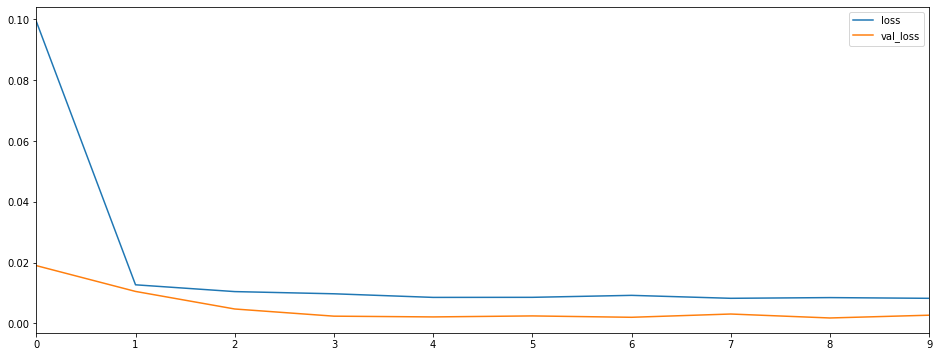

In [71]:
pd.DataFrame(model.history.history).plot(figsize = (16,6))

## Model Predicitons
- We will create a loop to predict the test size first prior to frecasting just to test the accuracy of the predictions

In [72]:
test_predictions = []
batch = train_scaled[-length:]
current_batch = batch.reshape((1,length,n_features))
for x in range(len(test)):
    current_prediction = model.predict(current_batch)[0]
    test_predictions.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis=1)

### Predicitons Inverse Scaling
- Our model was trained on scaled data so we need to inverse that operaton to get the true values

In [74]:
true_predictions = scalar.inverse_transform(test_predictions)

In [77]:
test["predictions"] = true_predictions

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Prediction Results
- Our model predicted 0.87 and the true value was 0.83 looks like we are not too far off
- Remember our model still had room for training we should consider this also 

In [80]:
test.head()

,rate,predictions
DATE,,
2020-03-26,0.83,0.875289
2020-03-27,0.72,0.842169
2020-03-30,0.70,0.831363
2020-03-31,0.70,0.839799
2020-04-01,0.62,0.839447


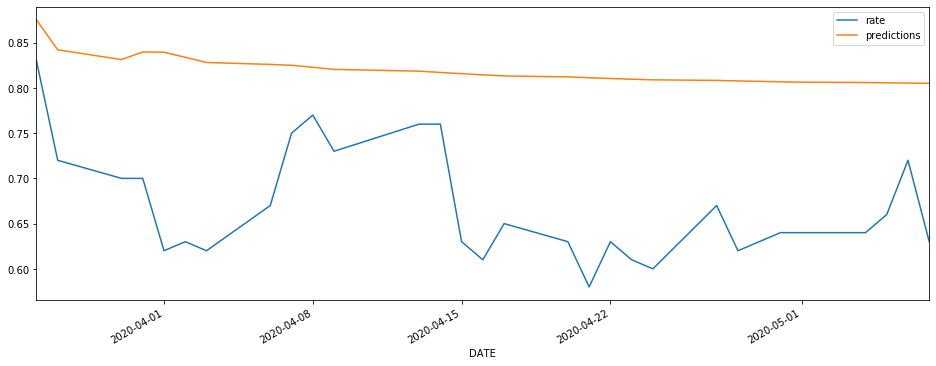

In [81]:
test.plot(figsize = (16,6))

## Forecasting
- We will forecasting 5 days into the future
- WE will again, only consider one day out

In [87]:
forecast = []
period = length
batch = train_scaled[-length:]
current_batch = batch.reshape((1,length,n_features))
for x in range(length):
    current_prediction = model.predict(current_batch)[0]
    forecast.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis=1)

In [88]:
forecast

[array([0.2502159], dtype=float32),
 array([0.22549905], dtype=float32),
 array([0.21743536], dtype=float32),
 array([0.22373065], dtype=float32),
 array([0.22346765], dtype=float32)]

In [89]:
true_forecast = scalar.inverse_transform(forecast)

In [90]:
true_forecast

array([[0.87528929],
       [0.84216873],
       [0.83136338],
       [0.83979908],
       [0.83944665]])

In [96]:
ten_Year_Treasury.tail()

DATE
2020-05-01    0.64
2020-05-04    0.64
2020-05-05    0.66
2020-05-06    0.72
2020-05-07    0.63
Name: rate, dtype: float64

In [95]:
ten_Year_Treasury_2020.tail()[-1:]

,rate
DATE,
2020-05-07,0.63


## Time Series for forecast
- Will need to create dates for the forecast values

In [97]:
dates = pd.date_range(start= "2020-05-08", periods=period, freq="B")

In [104]:
dates

DatetimeIndex(['2020-05-08', '2020-05-11', '2020-05-12', '2020-05-13',
               '2020-05-14'],
              dtype='datetime64[ns]', freq='B')

In [106]:
forecast_dataFrame = pd.DataFrame(true_forecast, index=dates, columns=["Forecast"])

(737485.0, 737559.0)

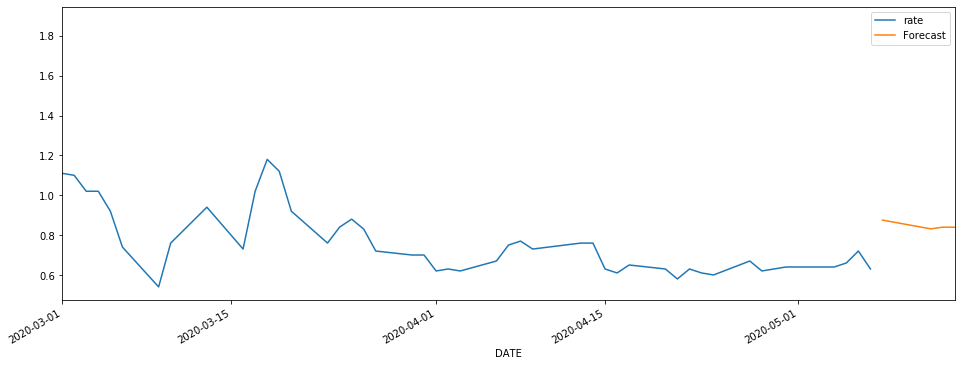

In [107]:
ax = ten_Year_Treasury_2020.plot(figsize = (16,6))
forecast_dataFrame.plot(ax =ax)
plt.xlim("2020-3-1", "2020-05-14")